In [1]:
import sys
sys.path.append('..')

In [3]:
!pip install scikit-learn-intelex

In [4]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


C:\Users\ssanj\AppData\Local\Temp\ipykernel_64196\2699702953.py:14: DtypeWarning: Columns (27,28,30,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep=';')


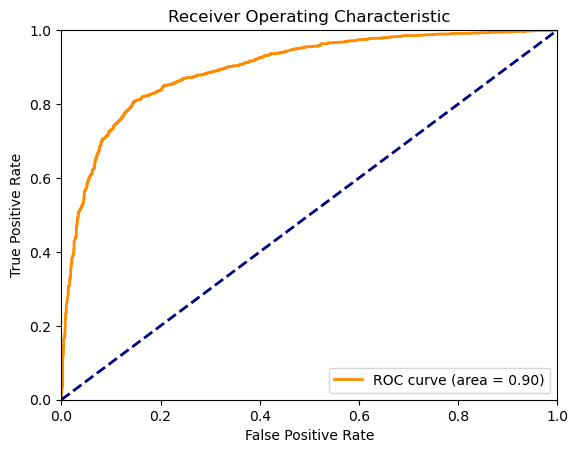

Optimal threshold for classification: 0.52
Accuracy with optimal threshold on the test set: 0.8304

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

    Inactive       0.82      0.85      0.84      1930
      Active       0.85      0.81      0.83      1903

    accuracy                           0.83      3833
   macro avg       0.83      0.83      0.83      3833
weighted avg       0.83      0.83      0.83      3833



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# Load data
pd.set_option('display.max_columns', None)
data_path = "ptd.csv"  # Change this to your CSV file path
df = pd.read_csv(data_path, sep=';')

# Filter the data by activity type (IC50)
activity_type = 'IC50'
relevant_columns = ['Molecule ChEMBL ID', 'Molecule Name', 'Molecular Weight', '#RO5 Violations', 'Smiles',
                   'Standard Value', 'Standard Units', 'pChEMBL Value']
df = df[(df['Standard Type'] == activity_type) & (df['Standard Relation'].str.contains('='))][relevant_columns]

# Drop rows where 'Smiles' is missing or NaN
df = df.dropna(subset=['Smiles'])

# Convert IC50 values into binary classes (Active/Inactive) using median
df['class'] = (df['Standard Value'] <= df['Standard Value'].median()).astype(int)  # Active = 1, Inactive = 0

# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Featurizer function to generate molecular fingerprints
def featurizer(df):
    X = []
    y = []
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(str(row['Smiles']))
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X.append(arr)
            y.append(row['class'])  # Use the binary class as the label
    return np.array(X), np.array(y)

# Featurize training and test data
X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)

# Set up hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Determine the optimal threshold based on ROC curve
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold for classification: {optimal_threshold:.2f}")

# Create binary classifications based on the optimal threshold
y_pred_binary = (y_prob >= optimal_threshold).astype(int)

# Calculate accuracy and other classification metrics using the new threshold
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy with optimal threshold on the test set: {accuracy_binary:.4f}")

# Print detailed classification report (precision, recall, F1-score) with the optimal threshold
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_binary, target_names=['Inactive', 'Active']))


In [6]:
import pickle

# Save the best model to a pickle file
with open('hepg2_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)


In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import pickle

# Load the saved model
model_path = 'hepg2_model.pkl'  # Path to your saved model
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Function to featurize SMILES strings
def featurizer(smiles_list):
    X = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X.append(arr)
        else:
            print(f"Invalid SMILES string: {smiles}")
            X.append(np.zeros(1024))  # Handle invalid SMILES by appending zeros
    return np.array(X)

# Input data: Replace these with new SMILES strings
new_data = pd.DataFrame({
    'Smiles': ['COc1ccc(cc1)Nc2nc(c(nc2Nc3ccc(cc3)C(F)(F)F)C4CC4)C(=O)Nc5ccc(OC)c(OC)c5']  # Example SMILES strings
})

# Featurize the SMILES strings
X_new = featurizer(new_data['Smiles'])

# Get predicted probabilities
y_prob_new = model.predict_proba(X_new)[:, 1]  # Probability of the active class

# Set threshold (you can adjust this based on your previous optimal threshold)
threshold = 0.5
y_pred_new = (y_prob_new >= threshold).astype(int)

# Add predictions to the dataframe
new_data['Predicted Class'] = y_pred_new
new_data['Probability Active'] = y_prob_new

# Output the predictions
print(new_data)


                                              Smiles  Predicted Class  \
0  COc1ccc(cc1)Nc2nc(c(nc2Nc3ccc(cc3)C(F)(F)F)C4C...                1   

   Probability Active  
0            0.559696  


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
pd.set_option('display.max_columns', None)
data_path = "ptd.csv"
df = pd.read_csv(data_path, sep=';')
df.head()

C:\Users\ssanj\AppData\Local\Temp\ipykernel_41408\2501689133.py:3: DtypeWarning: Columns (27,28,30,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep=';')


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL1829656,PTEROLINUS K,NaN,406.39,0.0,3.84,1,COC1=CC(=O)c2cc(-c3ccc(OC)c(O)c3)c3cc(O)c(OC)c...,IC50,'>',10.0,ug.mL-1,NaN,NaN,NaN,UO_0000274,NaN,NaN,NaN,NaN,0,CHEMBL1831793,Cytotoxicity against human HepG2 cells,F,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HepG2,NaN,NaN,NaN,NaN,CHEMBL395,HepG2,Homo sapiens,CELL-LINE,CHEMBL1828505,1,Scientific Literature,Bioorg Med Chem Lett,2011.0,CHEMBL3307718,NaN,NaN,NaN
1,CHEMBL61,PODOFILOX,4.0,414.41,0.0,2.41,2,COc1cc([C@@H]2c3cc4c(cc3[C@H](O)[C@H]3COC(=O)[...,IC50,'=',500.0,nM,6.3,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,0,CHEMBL1037946,Cytotoxicity against human HepG2 cells after 2...,F,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HepG2,NaN,NaN,NaN,NaN,CHEMBL395,HepG2,Homo sapiens,CELL-LINE,CHEMBL1156141,1,Scientific Literature,Eur J Med Chem,2010.0,CHEMBL3307718,NaN,NaN,NaN
2,CHEMBL578404,NaN,NaN,921.19,3.0,8.31,13,COc1cc2c(c(OC)c1OC)-c1ccc(SC)c(=O)cc1[C@@H](NC...,IC50,'=',500.0,nM,6.3,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,0,CHEMBL1037946,Cytotoxicity against human HepG2 cells after 2...,F,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HepG2,NaN,NaN,NaN,NaN,CHEMBL395,HepG2,Homo sapiens,CELL-LINE,CHEMBL1156141,1,Scientific Literature,Eur J Med Chem,2010.0,CHEMBL3307718,NaN,NaN,NaN
3,CHEMBL2334670,NaN,NaN,389.50,1.0,5.51,"Table S1, R6C1",CCN(CC)C(=O)c1c(/C=C\c2ccc3ccccc3c2)cc(OC)cc1OC,CC50,'>',100000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,0,CHEMBL2346279,Cytotoxicity against human HepG2 cells after 2...,A,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HepG2,NaN,NaN,NaN,NaN,CHEMBL395,HepG2,Homo sapiens,CELL-LINE,CHEMBL2331124,1,Scientific Literature,Bioorg Med Chem Lett,2013.0,CHEMBL3307718,NaN,NaN,NaN
4,CHEMBL316378,NaN,NaN,270.33,0.0,3.88,"Table S1, R1C7",COc1cc(/C=C/c2ccccc2)cc(OC)c1OC,CC50,'=',38400.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,0,CHEMBL2346279,Cytotoxicity against human HepG2 cells after 2...,A,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HepG2,NaN,NaN,NaN,NaN,CHEMBL395,HepG2,Homo sapiens,CELL-LINE,CHEMBL2331124,1,Scientific Literature,Bioorg Med Chem Lett,2013.0,CHEMBL3307718,NaN,NaN,NaN


In [4]:
activity_type = 'IC50'  # TODO: You can change this
relevant_columns = ['Molecule ChEMBL ID', 'Molecule Name', 'Molecular Weight', '#RO5 Violations', 'Smiles',
                    'Standard Value', 'Standard Units', 'pChEMBL Value']
df = df[(df['Standard Type'] == activity_type) & (df['Standard Relation'].str.contains('='))][relevant_columns]
df

,Molecule ChEMBL ID,Molecule Name,Molecular Weight,#RO5 Violations,Smiles,Standard Value,Standard Units,pChEMBL Value
1,CHEMBL61,PODOFILOX,414.41,0.0,COc1cc([C@@H]2c3cc4c(cc3[C@H](O)[C@H]3COC(=O)[...,500.0,nM,6.30
2,CHEMBL578404,NaN,921.19,3.0,COc1cc2c(c(OC)c1OC)-c1ccc(SC)c(=O)cc1[C@@H](NC...,500.0,nM,6.30
20,CHEMBL3427453,NaN,438.48,0.0,CC(=O)OC/C(C)=C\C[C@@]12OC(C)(C)[C@@H]3C[C@@H]...,5620.0,nM,5.25
37,CHEMBL1269313,NaN,737.96,2.0,CC1(C)[C@@H](O)CC[C@]2(C)[C@H]3C(=O)C=C4[C@@H]...,7400.0,nM,5.13
38,CHEMBL1269314,NaN,780.00,2.0,CC(=O)O[C@H]1CC[C@]2(C)[C@H]3C(=O)C=C4[C@@H]5C...,23720.0,nM,4.62
...,...,...,...,...,...,...,...,...
196324,CHEMBL5314060,NaN,484.69,1.0,Cc1ccc(-c2cccc3c(C(=O)NCCCN4CCC(N5CCCCC5)CC4)c...,5010.0,nM,5.30
196326,CHEMBL5311725,NaN,348.41,0.0,CC(C)(C)n1ncc2c(NCc3ccc4cccnc4c3O)ncnc21,6310.0,nM,5.20
196327,CHEMBL5310460,NaN,329.53,0.0,CCCc1cccc(CNC2CCN(C3CCN(C)CC3)CC2)c1,11000.0,nM,4.96
196329,CHEMBL5312669,NaN,375.48,0.0,c1ccc(CNc2ccc(-c3noc(C45CCCN(CCC4)C5)n3)cn2)cc1,20400.0,nM,4.69


In [5]:
df = df.dropna(subset=['Smiles'])

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
len(df_train), len(df_test)

(15331, 3833)

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

# Load data
pd.set_option('display.max_columns', None)
data_path = "PTD.csv"
df = pd.read_csv(data_path, sep=';')

# Filter the data by activity type
activity_type = 'IC50'
relevant_columns = ['Molecule ChEMBL ID', 'Molecule Name', 'Molecular Weight', '#RO5 Violations', 'Smiles',
                    'Standard Value', 'Standard Units', 'pChEMBL Value']
df = df[(df['Standard Type'] == activity_type) & (df['Standard Relation'].str.contains('='))][relevant_columns]

# Drop rows where 'Smiles' is missing or NaN
df = df.dropna(subset=['Smiles'])

# Convert IC50 values into binary classes (Active/Inactive) based on the threshold
activity_threshold = 100  # Threshold for classification (you can change this value)
df['class'] = (df['Standard Value'] <= activity_threshold).astype(int)  # Active = 1, Inactive = 0

# Split the dataset into training and testing
df_train, df_test = train_test_split(df, test_size=0.2)
len(df_train), len(df_test)

# Featurizer function using RDKit to generate molecular fingerprints
def featurizer(df):
    X = []
    y = []
    
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(str(row['Smiles']))
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X.append(arr)
            y.append(row['class'])  # Use the binary class as the label
    
    return np.array(X), np.array(y)

# Featurize training and test data
X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)

# Train a RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Calculate accuracy and other classification metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

# Print detailed classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Inactive', 'Active']))


C:\Users\ssanj\AppData\Local\Temp\ipykernel_9940\2903080593.py:13: DtypeWarning: Columns (27,28,30,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep=';')


Accuracy on the test set: 0.9512

Classification Report:
              precision    recall  f1-score   support

    Inactive       0.96      0.99      0.97      3442
      Active       0.87      0.61      0.72       391

    accuracy                           0.95      3833
   macro avg       0.91      0.80      0.85      3833
weighted avg       0.95      0.95      0.95      3833

